In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import statistics as stat
from pathlib import Path

In [25]:
date = '2019-01-31' # // 2019-01-31 // 2018-12-07
micscp = 'TIRF' #TIRF or DIC

p = 'C:\\Users\\brouhardlab\Documents\GitHub\sofia-brouhardlab\\'+date+'_'+micscp ## C:\\Users\sofia\OneDrive\Documentos\GitHub\sofia-brouhardlab\\
path = Path(p)
path.exists()

True

In [26]:
ch = ['11','12','13','21','22','23','31','32','33']
conc_name = ['7-5','15','6','10','17-5','12-5','12-5','10','7-5']
conc = [7.5,15,6,10,17.5,12.5,12.5,10,7.5]

#ch = ['22','23','31','32','33']
#conc_name = ['10','15','7-5','12-5','20']
#conc = [10,15,7.5,12.5,20]

t_interval = 10

In [27]:
def dynamics(k):
    
    filename = path/(date+'_CH'+ch[k]+'_'+conc_name[k]+'uM.csv')
    filename_s = path/(date+'_CH'+ch[k]+'_'+conc_name[k]+'uM_start.csv')
    
    data = pd.read_csv(filename,sep=',');
    supp = pd.read_csv(filename_s,sep=',');
    
    inter = t_interval;
    
    n = len(supp['Track ID'])
    start = sum(supp['Track duration (s)'])/n;
    
    ####################################
    
    oddID = [n-1 for n in data['Track ID'] if n%2]
    growth = []
    
    for i in oddID:
        g = abs(data['Track speed (um/s)'][i])*60;
        growth = np.append(growth,g)
       
    ####################################
    
    evenID = [n for n in data['Track ID'] if n%2]
    
    y1 = []
    lifetime = []
    
    for i in evenID:
        y1 = np.append(y1,min(data['y1'][i],data['y2'][i]))
        y2 = max(data['y1'][i],data['y2'][i])
        
        #if y2 < 130:
        lt = (data['Track duration (s)'][i]);
        lifetime = np.append(lifetime,lt/60)
    
    t_2_nuc = (y1*inter - start)/60;
    
    ######################################
        
    return growth, t_2_nuc , lifetime

In [28]:
def save_raw(j,name):

    track = dynamics(0)
    df = pd.DataFrame(track[j], columns=[str(conc[0])])

    for i in range(1,len(ch)):
    
        track = dynamics(i)
        df0 = pd.DataFrame(track[j], columns=[str(conc[i])])
        df = pd.concat([df, df0], axis=1, sort=False)

    df.to_csv(path/(date+'_'+name+'.csv'), encoding='utf-8', index=False)

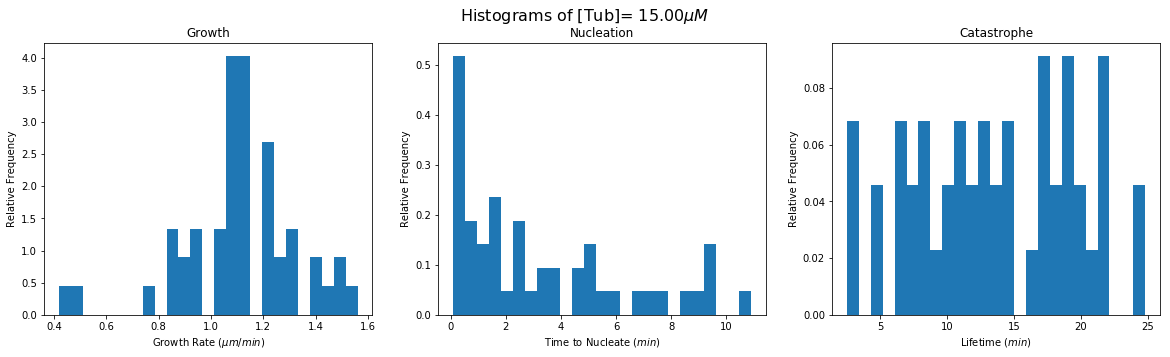

In [29]:
j=1
track = dynamics(j)
titles = ('Growth','Nucleation','Catastrophe')
xlables = ('Growth Rate ' r'$(\mu m / min)$','Time to Nucleate ' r'$(min)$','Lifetime ' r'$(min)$')

plt.figure(figsize=(20,5))
for i in [0,1,2] :
    
    plt.subplot(1,3,i+1)
    plt.hist(track[i],25, density=True)
    plt.ylabel('Relative Frequency')
    plt.xlabel(xlables[i])
    plt.title(titles[i]);

plt.suptitle('Histograms of [Tub]= %.2f' r'$\mu M$'%(conc[j]), fontsize=16)
plt.savefig(path/(date+'_histograms.png'))

In [30]:
name = ['growth','time2nuc','lifetime']

for j in [0,1,2]:
    save_raw(j,name[j])

In [31]:
def get_mean_std(name):
    data = pd.read_csv(path/(date+'_'+name+'.csv'),sep=',');

    mean = []
    sdev = []

    #mean = data.mean(axis=0)
    #sdev = data.std(axis=0)
    for i in data.columns:
        mean = np.append(mean,data[i].mean())
        sdev = np.append(sdev,data[i].std())
    
    df = pd.DataFrame([mean, sdev], columns=ch, index=[name+' mean', name+' std'])

    return df

In [32]:
df = get_mean_std(name[0])
df = df.append(get_mean_std(name[1]))
df = df.append(get_mean_std(name[2]))
df = df.T
df.insert(loc=0, column='tub conc', value=conc)
df.to_csv(path/(date+'_data.csv'), encoding='utf-8', index=True)

In [33]:
data = pd.read_csv(path/(date+'_data.csv'),sep=',', index_col=0);
data

,tub conc,growth mean,growth std,time2nuc mean,time2nuc std,lifetime mean,lifetime std
11,7.5,0.507391,0.077673,4.945652,3.764241,7.804348,4.603850
12,15.0,1.109388,0.222864,3.253401,3.107542,13.588435,6.025131
13,6.0,0.333000,0.066495,5.779167,4.053574,6.216667,3.749682
21,10.0,0.910345,0.348778,6.508621,4.319710,12.425287,6.903471
22,17.5,1.390769,0.274220,3.061966,3.370664,16.769231,8.172985
23,12.5,1.096216,0.254813,2.141892,2.712629,14.900901,7.534843
31,12.5,1.104828,0.355152,5.566092,3.816564,14.591954,6.489397
32,10.0,0.642857,0.134017,6.380952,3.370421,8.214286,4.594882
33,7.5,0.448000,0.081346,5.494444,4.428832,8.077778,6.250354


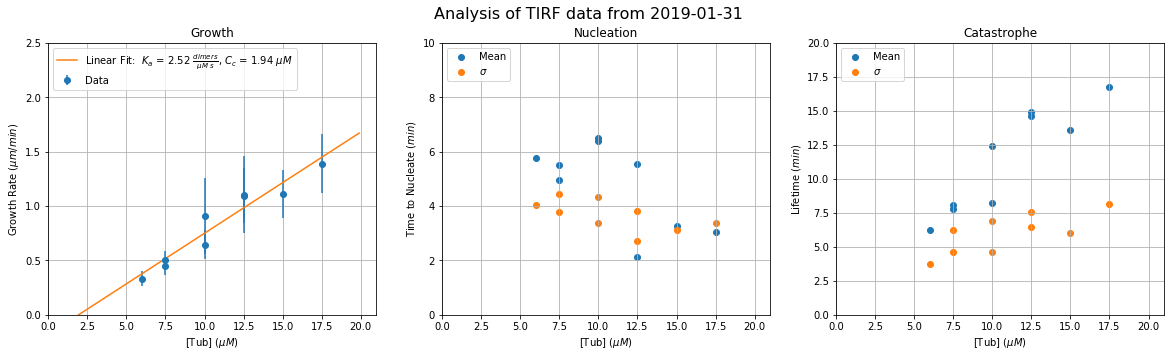

In [34]:
titles = ('Growth','Nucleation','Catastrophe')
ylables = ('Growth Rate ' r'$(\mu m / min)$','Time to Nucleate ' r'$(min)$','Lifetime ' r'$(min)$')

a1 , a0 = np.polyfit(data['tub conc'], data['growth mean'], 1)
y_int = -a0/a1
x_range = np.arange(0,20,0.1)

plt.figure(figsize=(20,5))
plt.suptitle('Analysis of '+micscp+' data from '+date, fontsize=16)

plt.subplot(1,3,1)
plt.errorbar(data['tub conc'], data['growth mean'], yerr=data['growth std'], fmt='o')
plt.plot(x_range, a1*x_range+a0)
plt.ylim(0,2.5)
plt.legend(('Linear Fit:  'r'$K_a$'' = %.2f 'r'$\frac{dimers}{\mu M \; s}$'', 'r'$C_c$'' = %.2f 'r'$\mu M$' %(a1*27.1, y_int),'Data'),loc='upper left')

plt.subplot(1,3,2)
plt.scatter(data['tub conc'], data['time2nuc mean'])
plt.scatter(data['tub conc'], data['time2nuc std'])
plt.ylim(0,10)
plt.legend(( 'Mean',r'$\sigma$'),loc='upper left')

plt.subplot(1,3,3)
plt.scatter(data['tub conc'], data['lifetime mean'])
plt.scatter(data['tub conc'], data['lifetime std'])
plt.ylim(0,20)
plt.legend(('Mean', r'$\sigma$'),loc='upper left')


for i in [0,1,2] :
    plt.subplot(1,3,i+1)
    plt.xlabel('[Tub] ' r'$(\mu M)$')
    plt.ylabel(ylables[i])
    plt.title(titles[i]);
    plt.xlim(0,21)
    plt.grid(True)
    
plt.savefig(path/(date+'_graphs.pdf'))
plt.savefig(path/(date+'_graphs.png'))